Welcome to our first lesson on the topic of **embeddings**. In this lesson, I'll show how to implement a model with embedding layers using the `tf.keras` API. Embeddings are a technique that enable deep neural nets to work with **sparse categorical variables**.

# Sparse Categorical Variables?

By this I mean a categorical variable with lots of possible values (high *cardinality*), with a small number of them (often just 1) present in any given observation. One good example is words. There are hundreds of thousands of them in the English language, but a single tweet might only have a dozen. Word embeddings are a crucial technique for applying deep learning to natural language. But other examples abound.

For example, [this dataset of LA county restaurant inspections](https://www.kaggle.com/meganrisdal/la-county-restaurant-inspections-and-violations) has several sparse categorical variables, including:
- `employee_id`: which of the health department's employees performed this inspection? (~250 distinct values)
- `facility_zip`: what zip code is the restaurant located in? (~3,000 distinct values)
- `owner_name`: who owns the restaurant? (~35,000 distinct values)

An embedding layer would be a good idea for using any of these variables as inputs to a network.

In this lesson, I'll be using the [MovieLens dataset](https://www.kaggle.com/grouplens/movielens-20m-dataset) as an example.

# MovieLens?

The MovieLens dataset consists of ratings assigned to movies by users. Here's a sample:

In [1]:
#$HIDE$
# Setup. Import libraries and load dataframes for Movielens data.
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import random

RUNNING_ON_KERNELS = 'KAGGLE_WORKING_DIR' in os.environ
input_dir = '../input' if RUNNING_ON_KERNELS else '../input/movielens_preprocessed'
ratings_path = os.path.join(input_dir, 'rating.csv')

ratings_df = pd.read_csv(ratings_path, usecols=['userId', 'movieId', 'rating', 'y'])

movies_df = pd.read_csv(os.path.join(input_dir, 'movie.csv'), usecols=['movieId', 'title', 'year'])

df = ratings_df.merge(movies_df, on='movieId').sort_values(by='userId')
df = df.sample(frac=1, random_state=1) # Shuffle

In [2]:
#$HIDE_INPUT$
df.sample(5, random_state=1)

,userId,movieId,rating,y,title,year
12904240,85731,1883,4.5,0.974498,Labyrinth,1986
6089380,45008,1221,4.5,0.974498,"Femme Nikita, La (Nikita)",1990
17901393,125144,3948,4.0,0.474498,The Alamo,1960
9024816,122230,3027,3.5,-0.025502,Toy Story 2,1999
11655659,21156,5202,3.0,-0.525502,My Big Fat Greek Wedding,2002


Ratings range from 0.5 stars to 5. Our goal will be to predict the rating a given user $u$ will give a particular movie $m$. 

`userId` and `movieId` are both sparse categorical variables. They have many possible values:

In [4]:
#$HIDE_INPUT$
n_movies = len(df.movieId.unique())
n_users = len(df.userId.unique())
print(
    "{1:,} distinct users rated {0:,} different movies (total ratings = {2:,})".format(
        n_movies, n_users, len(df),
    )
)

138,493 distinct users rated 26,744 different movies (total ratings = 20,000,263)


# Building a rating prediction model in Keras

We want to build a model that takes a user, $u_i$ and a movie, $m_j$, and outputs a number from 0.5-5, representing how many stars we think this user would give that movie. (You may have noticed that the [MovieLens dataset](https://www.kaggle.com/grouplens/movielens-20m-dataset) includes information about each movie such as its title, its year of release, a set of genres and user-assigned tags. But for now, we're not going to try to exploit any of that extra information.)

I claim we need an embedding layers to handle these inputs. Why? Let's review some alternatives and see why they don't work.

## Bad idea #1: Use user ids and movie ids as numerical inputs

Why not feed in user ids and movie ids as inputs, then add on some dense layers and call it a day? i.e.:

In [5]:
model = keras.Sequential([
    # 2 input values: user id and movie id
    keras.layers.Dense(256, input_dim=2, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    # A single output node, containing the predicted rating
    keras.layers.Dense(1)
])

In the simplest terms, neural nets work by doing math on their inputs. But the actual numerical values of the ids assigned to users and movies are meaningless. *Schindler's List* has id 527 and *The Usual Suspects* has id 50, but that doesn't mean *Schindler's List* is 'ten times bigger' than *The Usual Suspects*.

## Bad idea #2: One-hot encoded user and movie inputs

If you're not familiar with one-hot encoding, you may want to check out our lesson [Using Categorical Data with One Hot Encoding](https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding).

In that lesson, we claim that one-hot encoding is "The Standard Approach for Categorical Data". So why is it a bad idea here? Let's see what a model would look like that took one-hot encoded users and movies.

In [6]:
input_size = n_movies + n_users
print("Input size = {:,} ({:,} movies + {:,} users)".format(
    input_size, n_movies, n_users,
))
model = keras.Sequential([
    # One hidden layer with 128 units
    keras.layers.Dense(128, input_dim=input_size, activation='relu'),
    # A single output node, containing the predicted rating
    keras.layers.Dense(1)
])
model.summary()

Input size = 165,237 (26,744 movies + 138,493 users)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               21150464  
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 21,150,593
Trainable params: 21,150,593
Non-trainable params: 0
_________________________________________________________________


A basic issue here is scaling and efficiency. A single input to our model is a vector of 165,237 numbers (of which we know that 165,235 will be zeros). The feature data for our whole dataset of 20 million rating instances will require a 2-d array of shape (20,000,000, 165,237), or about 3 **trillion** numbers. Good luck fitting that all into memory at once!

Also, doing training and inference on our model will be inefficient. To calculate the activations of our first hidden layer, we'll need to multiply our 165k inputs through about 21 million weights - but the vast, vast majority of those products will just be zero.

One-hot encoding is fine for categorical variables with a small number of possible values, like `{Red, Yellow, Green}`, or `{Monday, Tuesday, Wednesday, Friday, Saturday, Sunday}`. But it's not so great in cases like our movie recommendation problem, where variables have tens or hundreds of thousands of possible values.

## Good idea: Embedding layers

In short, an **embedding layer** maps each element in a set of discrete things (like words, users, or movies) to a dense vector of real numbers (its **embedding**). 

> **Aside:** A key implementation detail is that embedding layers take as input the *index* of the entity being embedded (i.e. we can give it our userIds and movieIds as input). You can think of it as a sort of 'lookup table'. This is much more efficient than taking a one-hot vector and doing a huge matrix multiplication!

As an example, if we learn embeddings of size 8 for movies, the embedding for *Legally Blonde* (index=4352) might look like:

$$[ 1.624, -0.612, -0.528, -1.073,  0.865, -2.302,  1.745, -0.761]$$

**Where do these come from?** We initialize an embedding for each user and movie using random noise, then we train them as part of the process of training the overall rating-prediction model. 

**What do they mean?** An object's embedding, if it's any good, should capture some useful latent properties of that object. But the key word here is *latent* AKA hidden. It's up to the model to discover whatever properties of the entities are useful for the prediction task, and encode them in the embedding space. Sound mysterious? In later lessons I'll show some techniques for interpreting learned embeddings, such as visualizing them with T-SNE.

## Implementing it

I want my model to look something like this:

```
Editor's note: diagram is a WIP. Idea would be to repeat the fully-connected pattern for the other
two dense layers. (And remove the diamonds/orange dots. They were just guides for drawing the 
connection lines.)
```

<img src="https://docs.google.com/a/google.com/drawings/d/e/2PACX-1vQS_RaHKyLNtMTrP3_YFxaktNMBD-EIcI4X2ywpTStr3kP6pEHP9Rznz34b4ssvsGculNf4gJeuPAZR/pub?w=480&h=360" />

A key thing to note is that this network is not simply a stack of layers from input to output. We're treating the user and the movie as separate inputs, which come together only after each has gone through its own embedding layer.

This means that the [keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) class that we've been using up to this point won't work. We'll need to turn to the more powerful 'functional API', using the [keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model) class. For more detail on the Functional API, check out [Keras's guide, here](https://keras.io/getting-started/functional-api-guide/).

Here's the code:

In [7]:
hidden_units = (32,4)
movie_embedding_size = 8
user_embedding_size = 8

# Each instance will consist of two inputs: a single user id, and a single movie id
user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')
user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)
# Concatenate the embeddings (and remove the useless extra dimension)
concatenated = keras.layers.Concatenate()([user_embedded, movie_embedded])
out = keras.layers.Flatten()(concatenated)

# Add one or more hidden layers
for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation='relu')(out)

# A single output: our predicted rating
out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

model = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
movie_id (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 8)         1107952     user_id[0][0]                    
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 8)         213952      movie_id[0][0]                   
__________________________________________________________________________________________________
concatenat

## Training it

We'll compile our model to minimize squared error ('MSE'). We'll also include absolute error ('MAE') as a metric to report during training, since it's a bit easier to interpret.

> Something to think about: We know that ratings can only take on the values `{0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5}` - so why not treat this as a multiclass classification problem with 10 classes, one for each possible star rating?

In [8]:
tf.set_random_seed(1); np.random.seed(1); random.seed(1)
model.compile(
    # Technical note: when using embedding layers, I highly recommend using one of the optimizers
    # found  in tf.train: https://www.tensorflow.org/api_guides/python/train#Optimizers
    # Passing in a string like 'adam' or 'SGD' will load one of keras's optimizers (found under 
    # tf.keras.optimizers). They seem to be much slower on problems like this, because they
    # don't efficiently handle sparse gradient updates.
    tf.train.AdamOptimizer(0.005),
    loss='MSE',
    metrics=['MAE'],
)

Let's train the model.

> **Aside**: I'm passing in `df.y` as my target variable rather than `df.rating`. The `y` column is just a 'centered' version of the rating - i.e. the rating column minus its mean over the training set. For example, if the overall average rating in the training set was 3 stars, then we would translate 3 star ratings to 0, 5 star ratings to 2.0, etc. to get `y`. This is a common practice in deep learning, and tends to help achieve better results in fewer epochs. For more details, feel free to check out [this kernel](TODO) with all the preprocessing I performed on the MovieLens dataset.

In [9]:
#$HIDE_OUTPUT$
history = model.fit(
    [df.userId, df.movieId],
    df.y,
    batch_size=5000,
    epochs=20,
    verbose=2,
    validation_split=.05,
);

Train on 19000249 samples, validate on 1000014 samples
Epoch 1/20
 - 57s - loss: 0.7587 - mean_absolute_error: 0.6693 - val_loss: 0.7052 - val_mean_absolute_error: 0.6421
Epoch 2/20
 - 49s - loss: 0.6883 - mean_absolute_error: 0.6357 - val_loss: 0.6873 - val_mean_absolute_error: 0.6360
Epoch 3/20
 - 51s - loss: 0.6686 - mean_absolute_error: 0.6256 - val_loss: 0.6763 - val_mean_absolute_error: 0.6277
Epoch 4/20
 - 49s - loss: 0.6550 - mean_absolute_error: 0.6186 - val_loss: 0.6706 - val_mean_absolute_error: 0.6251
Epoch 5/20
 - 49s - loss: 0.6443 - mean_absolute_error: 0.6132 - val_loss: 0.6690 - val_mean_absolute_error: 0.6281
Epoch 6/20
 - 49s - loss: 0.6330 - mean_absolute_error: 0.6074 - val_loss: 0.6617 - val_mean_absolute_error: 0.6234
Epoch 7/20
 - 51s - loss: 0.6214 - mean_absolute_error: 0.6015 - val_loss: 0.6534 - val_mean_absolute_error: 0.6157
Epoch 8/20
 - 49s - loss: 0.6122 - mean_absolute_error: 0.5967 - val_loss: 0.6511 - val_mean_absolute_error: 0.6131
Epoch 9/20
 - 49s

To judge whether our model is any good, it'd be helpful to have a baseline. In the cell below, we calculate the error of a couple dumb baselines: always predicting the global average rating, and predicting the average rating per movie:

In [10]:
#$HIDE_INPUT$
from sklearn.model_selection import train_test_split
from sklearn import metrics

df_train, df_val = train_test_split(df, test_size=.05, random_state=1)

def get_metrics(y_true, y_pred):
    return metrics.mean_absolute_error(y_true, y_pred), metrics.mean_squared_error(y_true, y_pred)

mean_rating = df_train['rating'].mean()
print("Average rating in training set is {:.2f} stars".format(mean_rating))

y_true = df_val['rating'].values
always_mean = np.full(y_true.shape, mean_rating)

mae, mse = get_metrics(y_true, always_mean)
print("Always predicting global mean results in Mean Absolute Error={:.2f}, Mean Squared Error={:.2f}".format(
    mae, mse))

movies = movies_df.copy().set_index('movieId')
mean_per_movie = df_train.groupby('movieId')['rating'].mean()
movies['mean_rating'] = mean_per_movie
ratings_per_movie = df_train.groupby('movieId').size()
movies['n_ratings'] = ratings_per_movie
# There are a few movies in the validation set not present in the training set. We'll just use the global
# mean rating in their case.
y_movie_mean = df_val.join(mean_per_movie, on='movieId', rsuffix='mean')['ratingmean'].fillna(mean_rating).values

mae, mse = get_metrics(y_true, y_movie_mean)
print("Predicting mean per movie results in Mean Absolute Error={:.2f}, Mean Squared Error={:.2f}".format(mae, mse))

Average rating in training set is 3.53 stars
Always predicting global mean results in Mean Absolute Error=0.84, Mean Squared Error=1.10
Predicting mean per movie results in Mean Absolute Error=0.73, Mean Squared Error=0.88


Here's a plot of our embedding model's absolute error over time. For comparison, our best baseline (predicting the average rating per movie) is marked with a dotted line:

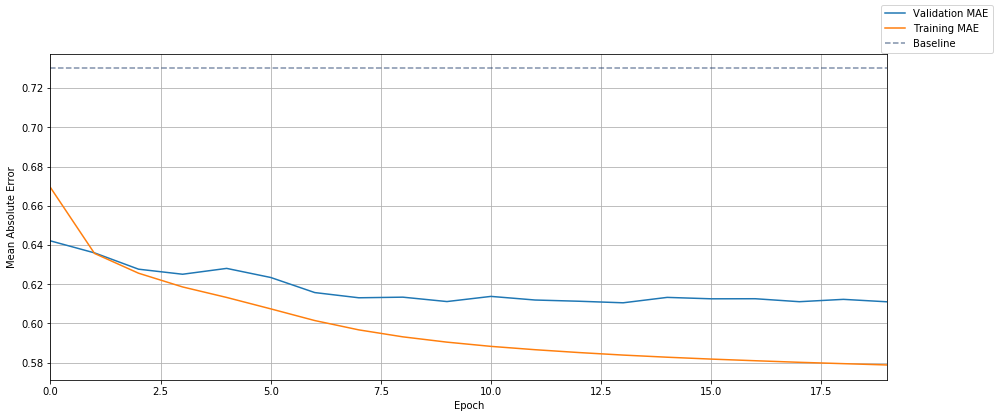

In [11]:
#$HIDE_INPUT$
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(history.epoch, history.history['val_mean_absolute_error'], label='Validation MAE')
ax.plot(history.epoch, history.history['mean_absolute_error'], label='Training MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0, right=history.epoch[-1])
baseline_mae = 0.73
ax.axhline(baseline_mae, ls='--', label='Baseline', color='#002255', alpha=.5)
ax.grid()
fig.legend();

In [12]:
#$HIDE_INPUT$
# Save training history for later comparison
hdf = pd.DataFrame(dict(
    epoch=history.epoch,
    val_mae=history.history['val_mean_absolute_error'],
    train_mae=history.history['mean_absolute_error'],
))
hdf.to_csv('history-1.csv')

Compared to the baseline, we were able to get our average error down by more than .1 stars (or about 15%). Not bad!

## Example predictions

Let's try some example predictions as a sanity check. We'll start by picking out a specific user from the dataset at random.

In [13]:
ratings_per_user = df.groupby('userId').size()
uid = ratings_per_user[ratings_per_user < 30].sample(1, random_state=1).index[0]
user_ratings = df[df.userId==uid]
print("User #{} has rated {} movies (avg. rating = {:.1f})".format(
    uid, len(user_ratings), user_ratings['rating'].mean(),
))
user_ratings.sort_values(by='rating', ascending=False)

User #26556 has rated 21 movies (avg. rating = 3.7)


,userId,movieId,rating,y,title,year
4421455,26556,2705,5.0,1.474498,Airplane!,1980
14722970,26556,2706,5.0,1.474498,Airplane II: The Sequel,1982
7435440,26556,2286,4.5,0.974498,Fletch,1985
16621016,26556,2216,4.5,0.974498,History of the World: Part I,1981
11648630,26556,534,4.5,0.974498,Six Degrees of Separation,1993
14805184,26556,937,4.5,0.974498,Mr. Smith Goes to Washington,1939
14313285,26556,2102,4.5,0.974498,Strangers on a Train,1951
13671173,26556,2863,4.5,0.974498,Dr. No,1962
13661434,26556,913,4.0,0.474498,Notorious,1946
11938282,26556,916,4.0,0.474498,To Catch a Thief,1955


User 26556 has given out two perfect ratings to the movies *Airplane!* and *Airplane II: The Sequel*. Great choices! Perhaps they'd also enjoy the [*The Naked Gun*](https://en.wikipedia.org/wiki/The_Naked_Gun) series - another series of spoof films starring Leslie Nielsen.

We don't have as much evidence about what this user hates. Rather than extrapolating from their few low ratings, a better indication of this user's dislikes might be the kinds of movies they haven't even rated. Let's also throw in a couple examples of movies that this user seems unlikely to ever watch, according to their rating history.

In [14]:
candidate_movies = movies[
    movies.title.str.contains('Naked Gun')
    | (movies.title == 'The Sisterhood of the Traveling Pants')
    | (movies.title == 'Lilo & Stitch')
].copy()

preds = model.predict([
    [uid] * len(candidate_movies), # User ids 
    candidate_movies.index, # Movie ids
])
# NB: Remember we trained on 'y', which was a version of the rating column centered on 0. To translate
# our model's output values to the original [0.5, 5] star rating scale, we need to 'uncenter' the
# values, by adding the mean back
row = df.iloc[0] # The difference between rating and y will be the same for all rows, so we can just use the first
y_delta = row.rating - row.y
candidate_movies['predicted_rating'] = preds + y_delta
# Add a column with the difference between our predicted rating (for this user) and the movie's
# overall average rating across all users in the dataset.
candidate_movies['delta'] = candidate_movies['predicted_rating'] - candidate_movies['mean_rating']
candidate_movies.sort_values(by='delta', ascending=False)

,title,year,mean_rating,n_ratings,predicted_rating,delta
movieId,,,,,,
3775,The Naked Gun: From the Files of Police Squad!,1988,3.580381,6973.0,4.865047,1.284666
366,Naked Gun 33 1/3: The Final Insult,1994,2.954226,13534.0,4.224319,1.270093
3776,The Naked Gun 2 1/2: The Smell of Fear,1991,3.132616,4415.0,4.395578,1.262962
5347,Lilo & Stitch,2002,3.489323,4402.0,3.484000,-0.005323
10138,The Sisterhood of the Traveling Pants,2005,3.369987,773.0,2.529076,-0.840911


Looks pretty reasonable! For each of the movies in the *The Naked Gun* series, our predicted ratings for this user are around a full star above the average rating in the dataset, and our 'out of left field' picks have their predicted ratings downgraded compared to average.

# Your turn

**TODO: Exercises link goes here**

In [15]:
# scratch space below